In [1]:
import numpy as np
import pandas as pd
import commonFunctions as func
import matplotlib.pyplot as plt
import folium

In [24]:
# pinnaclePoints = pd.read_csv('formattedSummits/pinnaclePoints_raw.txt', 
#                              sep = ',', 
#                              header = None,
#                              names = ['id', 'latitude', 'longitude', 'elevation', 'h_distance'])
# pinnaclePoints = pinnaclePoints[['latitude', 'longitude', 'elevation']]
# print(len(pinnaclePoints))

pinnaclePoints = pd.read_csv('pinnaclePoints.txt', sep=',').fillna('')
print(len(pinnaclePoints))

676


In [18]:
def getClosestExtremal(summit):
    
    distanceBetweenSummits = extremals.apply(lambda extremal: func.distanceBetweenPoints(extremal.latitude,
                                                                                         summit.latitude,
                                                                                         extremal.longitude,
                                                                                         summit.longitude), axis=1) 
    if distanceBetweenSummits.min() < 500:
        closestExtremal = extremals.iloc[distanceBetweenSummits.idxmin()]
        
        closestName = closestExtremal['name']
        closestNameEn = closestExtremal.name_en
        closestWiki = closestExtremal.wikipedia
        
        if pd.isna(closestName) == True:
            closestName = ''
        if pd.isna(closestNameEn) == True:
            closestNameEn = ''
        if pd.isna(closestWiki) == True:
            closestWiki = ''
        
    else:
        closestName = ''
        closestNameEn = ''
        closestWiki = ''
        
    return pd.Series({'name_local': closestName,
                      'name_en': closestNameEn,
                      'wikipedia': closestWiki})

#Only run this if you need to get the name and wiki data
#
# extremals = pd.read_csv('dataSources/formattedExtremals.csv')
# summits = pinnaclePoints
# summits[['name_local', 'name_en', 'wikipedia']] = summits.apply(lambda summit: getClosestExtremal(summit),
#                                                                 axis=1,
#                                                                 result_type='expand')  

In [32]:
summits = pinnaclePoints

def getHorizonColor(elevation):
    if elevation >= 6000:
        return 'red'
    elif elevation >= 4000:
        return 'orange'
    elif elevation >= 2000:
        return 'yellow'
    else:
        return 'limegreen'
    
def addPointToMap(summit):
    
    summitTitle = summit.name_local
    if summit.name_en != '' and summit.name_en != summit.name_local:
        summitTitle += f'<br>({summit.name_en})'
    summitTitleHTML = f'<a href=https://en.wikipedia.org/wiki/{summit.wikipedia.replace(" ","_")}><b>{summitTitle}</b></a>'
    if summitTitle != '':
        summitTitleHTML += '<br>'
    
    toolTip = (summitTitleHTML + 
               f'Latitude: {round(summit.latitude, 4)}<br>' + 
               f'Longitude: {round(summit.longitude, 4)}<br>' + 
               f'Elevation: &asymp;{round(summit.elevation)} m')    

    marker = folium.RegularPolygonMarker(
        location = [summit.latitude, summit.longitude],
        number_of_sides=3,
        radius = 9,
        fill = True,
        fill_color = getHorizonColor(summit.elevation),
        fill_opacity = 1,
        weight = 1,
        color = 'black',
        gradient = False,
        rotation = 30
    ).add_to(horizonMap)
    
    invisibleCircle = folium.CircleMarker(
        location = [summit.latitude, summit.longitude],
        radius = 10,
        fill = True,
        fill_opacity = 0,
        weight = 0
    ).add_to(horizonMap)
    
    invisibleCircle.add_child(folium.Popup(toolTip, max_width=300).add_to(invisibleCircle))
        
horizonMap = folium.Map(location=[0, 0], zoom_start=2, tiles=None, world_copy_jump=True)

folium.raster_layers.TileLayer(name = 'Satellite',
                               maxZoom = 19,
                               tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', 
                               attr = 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
                              ).add_to(horizonMap)
folium.TileLayer(
          'https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png', 
          attr = 'Map data: &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, <a href="http://viewfinderpanoramas.org">SRTM</a> | Map style: &copy; <a href="https://opentopomap.org">OpenTopoMap</a> (<a href="https://creativecommons.org/licenses/by-sa/3.0/">CC-BY-SA</a>)',
          name = 'Elevation',
          maxZoom = 16
          ).add_to(horizonMap)
folium.TileLayer(
          name = 'Street',
          ).add_to(horizonMap)

folium.LayerControl().add_to(horizonMap)

summits.apply(lambda summit: addPointToMap(summit), axis=1)    

legend_html = """
    <div style="
        background-color: rgba(255, 255, 255, 0.9);
        padding: 5px;
        font-size: 12px;
        position: absolute;
        top: 12px;
        right: 70px;
        z-index: 1000;
    ">
        <div style="display: flex; align-items: center; cursor: pointer;" onclick="toggleLegend()">
            <div id="chevronIcon" style="margin-left: 11px; margin-right: 15px; width: 10px; height: 10px; 
                border-style: solid; border-width: 0 2px 2px 0; transform: rotate(45deg);"></div>
            <h4 style="margin: 0; margin-right: 30px;">Earth's Pinnacle Points</h4>
        </div>
        <div id="legendContent" style="display: none; margin-top: 5px;">
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 16px; margin-right: 2px; margin-top: 12px">
                        <svg width="14" height="14">
                            <polygon points="0,14 7,1 14,14" fill="black" />
                        </svg>
                    </div>
                    <div class="col" style="margin-top: 7px">
                        <div class="col">A <b>pinnacle point</b> is a point from which<br>no higher point can be seen [Count: 676]</div>
                    </div>
                </div>
            </p>
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 16px; margin-right: 2px; margin-top: 4px">
                        <svg width="14" height="14">
                            <polygon points="0,14 7,1 14,14" fill="black" />
                            <polygon points="1.5,13 7,3.2 12.5,13" fill="limegreen" />
                        </svg>
                    </div>
                    <div class="col" style="margin-top: 7px">
                        <div class="col">Elevation < 2000 m</div>
                    </div>
                </div>
            </p>
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 16px; margin-right: 2px; margin-top: 4px">
                        <svg width="14" height="14">
                            <polygon points="0,14 7,1 14,14" fill="black" />
                            <polygon points="1.5,13 7,3.2 12.5,13" fill="yellow" />
                        </svg>
                    </div>
                    <div class="col" style="margin-top: 7px">
                        <div class="col">2000 &le; Elevation < 4000 m</div>
                    </div>
                </div>
            </p>
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 16px; margin-right: 2px; margin-top: 4px">
                        <svg width="14" height="14">
                            <polygon points="0,14 7,1 14,14" fill="black" />
                            <polygon points="1.5,13 7,3.2 12.5,13" fill="orange" />
                        </svg>
                    </div>
                    <div class="col" style="margin-top: 7px">
                        <div class="col">4000 &le; Elevation < 6000 m</div>
                    </div>
                </div>
            </p>
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 16px; margin-right: 2px; margin-top: 4px">
                        <svg width="14" height="14">
                            <polygon points="0,14 7,1 14,14" fill="black" />
                            <polygon points="1.5,13 7,3.2 12.5,13" fill="red" />
                        </svg>
                    </div>
                    <div class="col" style="margin-top: 7px">
                        <div class="col">Elevation &ge; 6000 m</div>
                    </div>
                </div>
            </p>
        </div>
    </div>

    <script>
        function toggleInfoWindow() {
            var infoWindow = document.getElementById("infoWindow");
            var infoIcon = document.getElementById("informationIcon");

            if (infoWindow.style.display === "block") {
                infoWindow.style.display = "none";
                infoIcon.style.fill = "rgba(255, 255, 255, 0.9)";
            } else {
                infoWindow.style.display = "block";
                infoIcon.style.fill = "rgba(255, 255, 0, 0.9)";
            }
        }
    </script>

    <script>
        function toggleLegend() {
            var contentDiv = document.getElementById("legendContent");
            var chevronIcon = document.getElementById("chevronIcon");

            if (contentDiv.style.display === "block") {
                contentDiv.style.display = "none";
                chevronIcon.style.transform = "rotate(45deg)";
            } else {
                contentDiv.style.display = "block";
                chevronIcon.style.transform = "rotate(225deg)";
            }
        }
    </script>
"""

horizonMap.get_root().html.add_child(folium.Element(legend_html))

horizonMap.get_root().html.add_child(folium.Element(f'''
    <div id="infoIcon" style="position: absolute; bottom: 15px; right: 5px; cursor: pointer; z-index: 1001;">
        <svg id="informationIcon" width="80" height="80" viewBox="0 0 50 50" fill="white" stroke="black" stroke-width="4" 
            stroke-linecap="round" stroke-linejoin="round" onclick="toggleInfoWindow()">
            <circle cx="24" cy="24" r="20"></circle>
            <line x1="24" y1="32" x2="24" y2="24"></line>
            <line x1="24" y1="16" x2="24" y2="16"></line>
        </svg>
    </div>
    <div id="infoWindow" style="display: none; overflow-y: auto; position: absolute; top: 50%; left: 50%; 
        transform: translate(-50%, -50%); background-color: rgba(255, 255, 255, 0.9); padding: 10px; width: 80%; 
        height: 80%;  z-index: 1000;">
        <h2>Definitions</h2>
        <p>A <b>pinnacle point</b> is a point from which no higher point can be seen in a direct line of sight.</p>
        <p>
            More specifically, 
            a pinnacle point is a point with zero <b>inferiority</b>, where inferiority is defined as the maximum elevation 
            that can be seen in a direct line of sight from a point minus the point's elevation. 
            Since all points can see themselves, the minimum possible inferiority is zero.
        </p>
        <h2>Datasets</h2>
        <h4><a href="http://everymountainintheworld.com/">Mountains by Topographic Prominence</a></h4>
        <p>
            Prominence is a measure of how much a summit rises above its surroundings. More specifically, it measures how far
            down you have to go in order to get to a higher elevation. Thanks to Andrew Kirmse for finding 11,866,713 summits
            with a prominence greater than 30 feet (9.1 m).
        </p>
        <h4><a href="https://ototwmountains.com/">On-Top-Of-The-World Mountains</a></h4>
        <p>
            An on-top-of-the-world mountain (OTOTW) is a summit where no land rises 
            above the horizontal plane from the summit. 
            Since any land that rises above the horizontal plane would have higher elevation than the summit itself, if a summit 
            is not an OTOTW then it can't be a pinnacle point either. In other words, pinnacle points are a subset of 
            OTOTWs. Thanks to Kai Xu for finding 6,464 OTOTWs around the world. Andreas Geyer-Schulz deserves 
            mention as well for his <a href="https://nuntius35.gitlab.io/extremal_peaks/">extremal peaks</a>.
        </p>
        
        <h2>Algorithms</h2>
        <h4>Finding Pinnacle Points</h4>
        <ol>
            <li>
                Categorize the 11,866,713 summits into patches based on longitude and latitude. 
                This is done for faster processing later. The patch size is 5 deg x 5 deg with some extra to take into account
                the fact that summits may be able to see beyond the patch they are in.
            </li>
            <li>
                Find the maximum horizon distance (MHD) defined as √(2*R_earth*Elevation) for each summit and OTOTW.
            </li>
            <li>
                Define a list of "Remaining OTOTWs" as the full list of OTOTWs.
            </li>
            <li>
                Find the highest elevation Remaining OTOTW (HERO).
            </li>
            <li>
                Find all other remaining OTOTWs where the sum of the OTOTW's MHD and the HERO's MHD 
                is greater than the distance between them. In other words, find all OTOTWs that have a chance 
                of being seen by the HERO. For each, do line of sight analysis (described below) to find which OTOTWs 
                can actually be seen by the HERO. Each will have a lower elevation than the HERO, so they are removed from the 
                list of remaining OTOTWs.
            </li>
            <li>
                Find the HERO's patch.
            </li>
            <li>
                Find all summits in the patch where both the summit's elevation is greater than the HERO's elevation 
                and the sum of the summit's MHD and the HERO's MHD is greater than the distance between them. In other 
                words, find all summits that have a chance of disqualifying the HERO from being a pinnacle point. For each, 
                do line of sight analysis to determine if any summits can actually see the HERO. If any can, the HERO is 
                not a pinnacle point and is removed from the list of remaining OTOTWs. Otherwise, the HERO is a pinnacle 
                point and is added to a list.
            </li>
            <li>
                Repeat 4-8 until there are no remaining OTOTWs.
            </li>
        </ol>
        <h4>Line of Sight Analysis</h4>
        <ol>
            <li>
                Generate a list of 100 latitude-longitude points between the two input points along the geodesic.
            </li>
            <li>
                Find the elevation of each point using an API (thanks to 
                <a href="https://open-meteo.com/en/docs/elevation-api">Open-Meteo</a>), 
                and find the distance of each point to the first point.
            </li>
            <li>
                Translate each distance-elevation point such that the first point is at (0, 0).
            </li>
            <li>
                Apply a vertical drop to each elevation according to how far away the point is to take the 
                curvature of the earth into account.
            </li>
            <li>
                Rotate the points to make the last point at the 0 elevation line. In other words, 
                make the line of sight along the x-axis.
            </li>
            <li>
                If the maximum of the points is greater than 0, line of sight is blocked. Otherwise, 
                there is direct line of sight.
            </li>
        </ol>
        <h2>Sources of Error</h2>
        <ol>
            <li>
                When the OTOTWs were found, all summits with less than 100 m of promince were omitted. 
                This cutoff is carried forward to pinnacle points.
            </li>
            <li>
                The earth is approximated as a sphere.
            </li>
            <li>
                Atmospheric refraction is not taken into account. If it was, it would decrease the number of found 
                pinnacle points since atmospheric refraction increases how far you can see.
            </li>
            <li>
                Only 100 elevations are sampled when determining if two points have line of sight. This can lead to points 
                that can block line of sight being missed. By increasing the number of elevations sampled, 
                more pinnacle points would be found.
            </li>
            <li>
                There is some inherent error in the data. The datasets have a resolution of 30 m (1 arcsecond), and the API 
                uses 90 m (3 arcsecond). All data sources are surface elevation models, so trees and buildings are included. 
            </li>
        </ol>
        <h2>Contact</h2>
        <p>
            Check out the latest on <a href="https://github.com/jgbreault/PinnaclePoints">my github</a>. 
            There, you can find a txt file of all pinnacle points.
            Contact me at jamiegbreault@gmail.com.
        </p>
    </div>
'''))


horizonMap

In [137]:
summits.to_csv(f'pinnaclePoints.txt', index=False)
horizonMap.save('index.html')

In [9]:
LAT = 0 # latitude
LNG = 1 # longitude
def findClosestPinnaclePoints(lat, lng, summits=pinnaclePoints, num=5):
        
    distances = [func.distanceBetweenPoints(lat,
                                            row[LAT],
                                            lng,
                                            row[LNG])
                 for row in summits.values]
    
    distances = pd.Series(distances).sort_values().divide(1000).round(1)
    closestDistances = distances.head(num)
    closestPinnaclePoints = summits.loc[closestDistances.index]
    closestPinnaclePoints['distance_km'] = closestDistances
        
    return closestPinnaclePoints

findClosestPinnaclePoints(45.4236, -75.7009, num=8)

,latitude,longitude,elevation,distance_km
587,45.6489,-78.2569,582.7,200.6
267,44.2705,-71.3034,1916.6,369.6
381,41.9991,-74.3860,1274.1,395.2
537,48.8042,-73.5900,737.3,408.4
516,41.9056,-77.7028,787.3,423.0
401,47.3094,-70.8322,1169.3,428.3
601,46.1111,-81.2894,538.3,440.1
551,47.3175,-80.7525,691.0,441.0


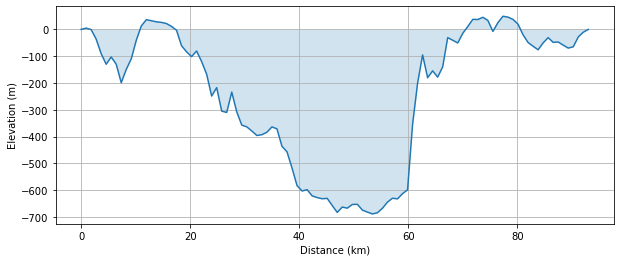

In [11]:
def plotLosElevationProfile(lat1, lng1, elv1, lat2, lng2, elv2):
    
    dists, elvs = func.getLosData(lat1, lng1, elv1, lat2, lng2, elv2)
    dists = dists/1000 # m to km
    
    plt.figure(figsize=(10,4))
    plt.plot(dists, elvs)
    plt.fill_between(dists, elvs, 0, alpha=0.2)
    plt.xlabel("Distance (km)")
    plt.ylabel("Elevation (m)")
    plt.grid()
    plt.show()
    
plotLosElevationProfile(-8.8611, 27.0653, 1908, -9.2442, 27.8183, 1790)
